In [1]:
import os
import torch
import copy
import matplotlib.pyplot as plt

from bmadx.beam_generator import create_beam

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.analysis import plot_scan_data, plot_predicted_screens

In [2]:
data_dir = 'data'

In [3]:
# create synthetic ground truth beam from base and transform yaml files
gt_beam = create_beam(base_yaml = os.path.join(data_dir,'base.yaml'),
                      transforms_yaml = os.path.join(data_dir,'transforms.yaml'), 
                      p0c = 10.0e6,
                      save_as = os.path.join('data', 'gt_beam.pt'))

ground truth distribution saved at data/gt_beam.pt


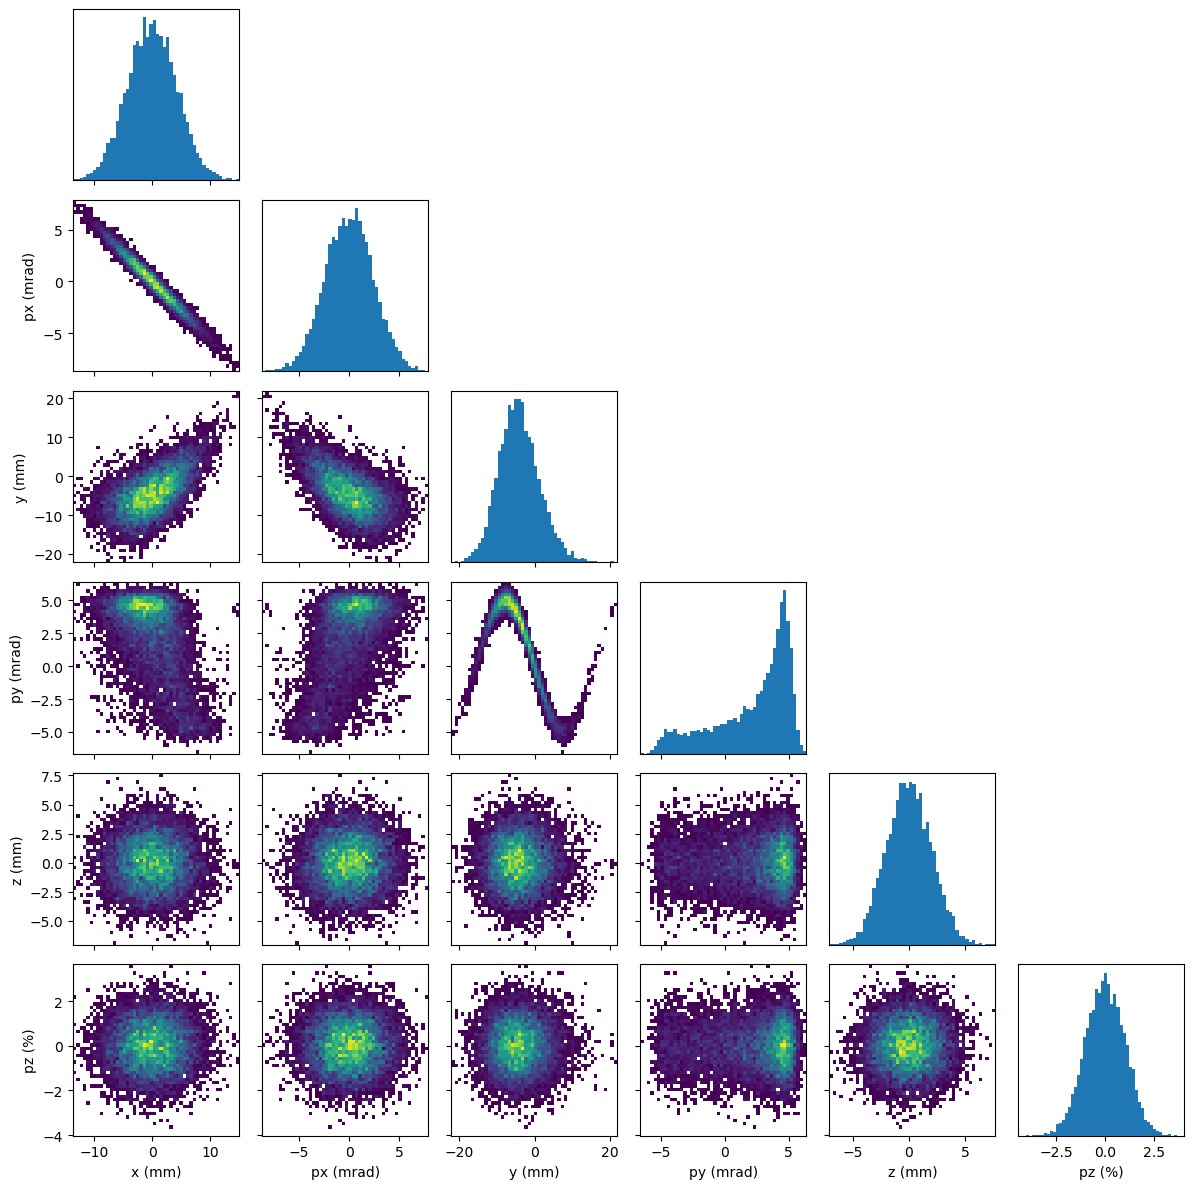

In [4]:
# plot synthetic ground truth beam projections 
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [5]:
# diagnostic beamline:
lattice = quad_drift()

# design momentum (eV)
p0c = torch.tensor(10.0e6)

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-25, 15, n_ks).reshape((n_ks,1,1))

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen: 
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

/home/jp/Repositories/PS-Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [6]:
lattice.elements[0].K1

Parameter containing:
tensor(0.)

In [7]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test.dset'))

dataset saved as 'data/train.dset'
dataset saved as 'data/test.dset'


In [24]:
train_dset.k.shape

torch.Size([10, 1, 1])

In [8]:
lattice.elements[0].K1

Parameter containing:
tensor(0.)

image size = 60 x 60 mm
test samples boxed in orange


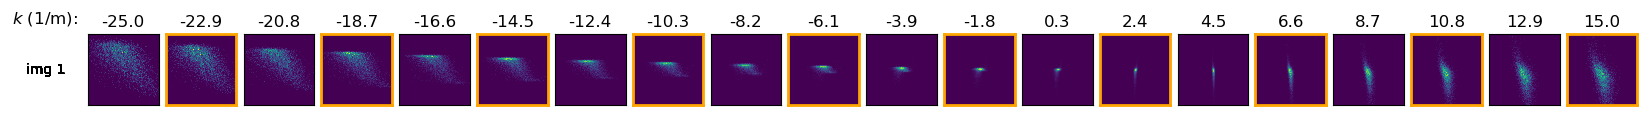

In [9]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [16]:
from phase_space_reconstruction import modeling
from torchensemble.snapshot_ensemble import SnapshotEnsembleRegressor
from torch.utils.data import DataLoader
from phase_space_reconstruction.losses import MENTLoss

In [17]:
def create_ensemble(lattice, p0c, screen):
    # create NN beam
    n_particles = 10000
    nn_transformer = modeling.NNTransform(2, 20, output_scale=1e-2)
    nn_beam = modeling.InitialBeam(
        nn_transformer,
        torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)),
        n_particles,
        p0c=p0c,
    )
    module_kwags = {"lattice": lattice.copy(), "diagnostic": screen, "beam": nn_beam}

    ensemble = SnapshotEnsembleRegressor(
        estimator = modeling.PhaseSpaceReconstructionModel,
        estimator_args = module_kwags,
        n_estimators = 5,
    )

    return ensemble

In [41]:
def train(train_dset, 
          lattice, 
          p0c, 
          screen, 
          n_epochs= 1000,
          save_dir=''):
    
    train_loader = DataLoader(train_dset, batch_size=5, shuffle=True)

    n_particles = 10000
    nn_transformer = modeling.NNTransform(2, 20, output_scale=1e-2)
    nn_beam = modeling.InitialBeam(
        nn_transformer,
        torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)),
        n_particles,
        p0c=p0c,
    )
    module_kwags = {"lattice": lattice, "diagnostic": screen, "beam": nn_beam}

    model = SnapshotEnsembleRegressor(
        estimator = modeling.PhaseSpaceReconstructionModel,
        estimator_args = module_kwags,
        n_estimators=5,
        cuda=True
    )
    

    criterion = MENTLoss(
        torch.tensor(1e11), 
    )
    #criterion = MENTLoss(torch.tensor(1e3), gamma_=torch.tensor(0.01))
    model.set_criterion(criterion)
    model.set_optimizer("Adam", lr=1e-2, weight_decay=5e-4)
    # with torch.autograd.detect_anomaly():
    model.fit(
        train_loader, epochs=n_epochs, save_dir=save_dir
    )
    torch.save(criterion.loss_record, save_dir + "/loss_log.pt")

In [42]:
train(train_dset, lattice, p0c, screen, n_epochs=1000, save_dir=data_dir)

type: _foreach_addcdiv_() received an invalid combination of arguments - got (list, list, tuple, list), but expected one of:
 * (tuple of Tensors self, tuple of Tensors tensor1, tuple of Tensors tensor2, tuple of Scalars scalars)
      didn't match because some of the arguments have invalid types: (!list of [Parameter, Parameter, Parameter, Parameter, Parameter, Parameter, Parameter, Parameter]!, !list of [Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]!, !tuple of (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor)!, !list of [Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]!)
 * (tuple of Tensors self, tuple of Tensors tensor1, tuple of Tensors tensor2, Tensor scalars)
      didn't match because some of the arguments have invalid types: (!list of [Parameter, Parameter, Parameter, Parameter, Parameter, Parameter, Parameter, Parameter]!, !list of [Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]!, !tuple of (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, 